# Thermal Image Enhancement Network (TEN) - IROS 2016
Thermal Image Enhancement using Convolution Neural Network

In [7]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.autograd import Variable

from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import imageio

import os
import random
from time import time

from sklearn.feature_extraction import image

from tqdm import tqdm

%matplotlib inline

## Parameters

In [8]:
learning_rate = 0.001
num_epochs = 2
weight_decay = 5e-4
scale_factor = 2

## Helper Methods

In [9]:
def blur_and_upscale(patch,scale_factor):
    patch = gaussian_filter(patch,sigma=scale_factor)
#     patch = imresize(patch,(36*scale_factor,36*scale_factor),interp='cubic')
    return patch

In [10]:
def save_checkpoint(state, output_dir, filename):
    torch.save(state, os.path.join(output_dir,filename))

## Image Transforms

In [11]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
])

## Dataset

In [12]:
dataset_train_path = '/DATA1/chaitanya/ninad3/dataset/rgb91/'
assert(os.path.exists(dataset_train_path))

In [13]:
class rgb91(Dataset):
    
    def __init__(self,path,scale,transform=None):
        
        assert(os.path.exists(path))
        self.path = path
        self.scale = scale
    
    def __len__(self):
        
        return len(os.listdir(self.path))
    
    def __getitem__(self,idx):
        
        infoDict = {}
        infoDict['idx'] = idx
        
        imgList = os.listdir(self.path)
        imgName = imgList[idx]
        
        imgPath = os.path.join(self.path,imgName)
        
        infoDict['name'] = imgName
        infoDict['path'] = imgPath
        
        imgOriginal = imageio.imread(imgPath).dot([0.299, 0.587, 0.114])
                
        infoDict['width'] = imgOriginal.shape[0]
        infoDict['height'] = imgOriginal.shape[1]

        infoDict['image'] = imgOriginal
        
        orig_patches = image.extract_patches_2d(imgOriginal, (36, 36))
        
        orig_patch_list = []
        patches = []
        
        for i in range(orig_patches.shape[0]):
            orig_patch_list.append((torch.from_numpy(orig_patches[i]).unsqueeze(0).unsqueeze(0)).float().cuda())
            patches.append((torch.from_numpy(blur_and_upscale(orig_patches[i],self.scale)).unsqueeze(0).unsqueeze(0)).float().cuda())
            
        infoDict['orig_patches'] = orig_patch_list
        infoDict['patches'] = patches
        
        return infoDict

In [14]:
dataset = rgb91(dataset_train_path,scale_factor,transform=img_transform)

## Model

In [15]:
class ten(nn.Module):
    def __init__(self):
        super(ten, self).__init__()
        self.model = nn.Sequential(

            nn.Conv2d(1,64,7,stride=1,padding=3),
            nn.ReLU(True),

            nn.Conv2d(64,32,5,stride=1,padding=2),
            nn.ReLU(True),

            nn.Conv2d(32,32,3,stride=1,padding=1),
            nn.ReLU(True),

            nn.Conv2d(32,1,3,stride=1,padding=1)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [16]:
model = torch.nn.DataParallel(ten()).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

## Run the model

In [ ]:
# Deletes old output
# !rm ../output/try2/*

model_output_dir = '../output/try5/model'

logs = open('../output/try5/logs.txt',"w")
logs.write('Thermal Enhancement Network (TEN) - Results\n\n')

total_epoch_time = 0
losses = []
epoch_num = 0

for epoch in tqdm(range(num_epochs)):
    
    epoch_num += 1
    
    logs.write('Epoch {epoch_num} Start')plt.imrea
    print(f'<----- START EPOCH {epoch_num} ------->\n')
    
    saveImg = random.choice([f for f in os.listdir(dataset_train_path) if f.endswith('.bmp')])
      
    start = time()    
    
    for ind, imgDict in enumerate(dataset):
        
        print("Image index ",ind,imgDict['name'])
        
        origPatches = imgDict['orig_patches']
        patches = imgDict['patches']
        
        patches = 
        
#         out = []
        
#         for orig,patch in zip(origPatches,patches):
#             patch = Variable(patch).cuda()
            
#             print("Sending patch forward...")
            
#             # forward
#             output = model(patch)
#             loss = criterion(output, orig)

#             # save results
#             pict = output.cpu().data
#             out.append(pict)

#             # backward
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#         if saveImg == imgDict['name']:
#             outPatches = [x.numpy() for x in out]
#             outPatches = np.array(outPatches)
#             outPatches = np.squeeze(outPatches)
#             reconst_image = image.reconstruct_from_patches_2d(outPatches,(imgDict['height'],imgDict['width']))
#             plt.imsave(f'../output/try5/reconst/epoch{epoch_num}_{imgDict["name"]}',reconst_image)
#             logs.write(f'Saved reconstructed image. Original Image {imgDict["name"]}')
#             print(f'Saved reconstructed image. Original Image {imgDict["name"]}')
            
        
    epoch_time = time() - start
    total_epoch_time += epoch_time
    
    logs.write('Epoch {epoch_num} End')
    print(f'<----- END EPOCH {epoch_num} ------->\n')
    
    losses.append(loss.item())
    
    logs.write(f'Epoch {epoch_num}/{num_epochs}, loss {loss.item():.4f}, time {epoch_time:.4f} s \n')
    
    # Save/Update current model
    save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, model_output_dir, filename=f'current.pth')
    logs.write(f'Model Saved: Epoch {epoch_num} \n')
    
    # Save model every 20 epochs

    if epoch%20 == 0 or epoch == num_epochs-1:
        
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, model_output_dir, filename=f'model_{epoch_num}.pth')
        
        logs.write(f'Model Saved: Epoch {epoch_num} \n')
    
    # Decay learning rate by 10 every 30 epochs until 60 epochs
    
    if (epoch_num)%30 == 0 and (epoch_num<=59):
        learning_rate = learning_rate/10
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate
        logs.write(f'Learning Rate set to {learning_rate}\n')
        print(f'Learning Rate set to {learning_rate}')
        
    
    print(f'\n<----- END EPOCH {epoch_num} ------->\n')

print(f'Average Time: {total_epoch_time/num_epochs:.4f} seconds')
print(f'Average Loss: {sum(losses) / len(losses):.4f}')

logs.write(f'\n\nAverage Time: {total_epoch_time/num_epochs:.4f} seconds\n')
logs.write(f'\nAverage Loss: {sum(losses) / len(losses):.4f}\n')
logs.write('\n\nLOSSES Array\n[')
for x in losses:
    logs.write(str(x))
    logs.write(', ')
logs.write(']')
logs.write('\n\nAll epochs completed!\n\n')
logs.close()

  0%|          | 0/2 [00:00<?, ?it/s]

<----- START EPOCH 1 ------->



In [ ]:
img = PIL.Image.open(os.path.join(dataset_train_path,'t3.bmp')).convert('LA')
print(img.size)
plt.imshow(img)
plt.show()
img = img.filter(ImageFilter.GaussianBlur(radius=2))
img = img.resize((36*2,36*2),PIL.Image.BICUBIC)
img = np.array(img)
# plt.imshow(img)
# plt.show()
img2 = PIL.Image.fromarray(img,'LA')
plt.imshow(img2)
plt.show()
img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
plt.imshow(img,cmap='gray')
imgPatches = image.extract_patches_2d(gray, (36, 36))
print(imgPatches[0].shape)

In [144]:
imgPatches.shape
x = []
for t in range(imgPatches.shape[0]):
    x.append(imgPatches[t])
print(len(x))
np.array(x).shape

22842


(22842, 36, 36)

(155, 191)


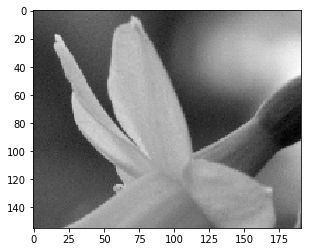

In [272]:
img = imageio.imread(os.path.join(dataset_train_path,'t3.bmp')).dot([0.299, 0.587, 0.114])
plt.imshow(img,cmap='gray')
print(img.shape)

In [20]:
import imageio

In [25]:
a = mpimg.imread('../dataset/rgb91/t1.bmp')
a.shape

(176, 197, 3)

In [26]:
mpimg.imsave('a.bmp',a)

ValueError: Format 'bmp' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)